In [1]:
import comparison as cmp
import numpy as np
import scipy.special as sc_spc
TWOPI = cmp.TWOPI

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

AX_LABELS_FS = 17.5
AX_TICKS_FS = 12.5
LEGEND_FS = 15

In [3]:
!ls MD_DATA

data_a02_n06.npz  data_a04_n10.npz  data_a06_n14.npz  data_a10_n06.npz
data_a02_n08.npz  data_a04_n12.npz  data_a06_n16.npz  data_a10_n08.npz
data_a02_n10.npz  data_a04_n14.npz  data_a08_n06.npz  data_a10_n10.npz
data_a02_n12.npz  data_a04_n16.npz  data_a08_n08.npz  data_a10_n12.npz
data_a02_n14.npz  data_a06_n06.npz  data_a08_n10.npz  data_a10_n14.npz
data_a02_n16.npz  data_a06_n08.npz  data_a08_n12.npz  data_a10_n16.npz
data_a04_n06.npz  data_a06_n10.npz  data_a08_n14.npz
data_a04_n08.npz  data_a06_n12.npz  data_a08_n16.npz


In [4]:
!pwd

/home/michele/contact_line_model


In [5]:
# Some useful definitions...
cos = lambda t : np.cos( np.deg2rad(t) )
sin = lambda t : np.sin( np.deg2rad(t) )
tan = lambda t : np.tan( np.deg2rad(t) )
cot = lambda t : 1.0/np.tan( np.deg2rad(t) )
tan_m1 = lambda t : np.rad2deg(np.arctan(t))
cos_m1 = lambda t : np.rad2deg(np.arccos(t))
sin_m1 = lambda t : np.rad2deg(np.arcsin(t))

In [6]:
# Load MD simulation output
n_tags = ['06','08','10','12','14','16']
n_range = [6,8,10,12,14,16]
md_output = dict()
for nt in n_tags :
    md_output[nt] = np.load("MD_DATA/data_a10_n"+nt+".npz")

In [7]:
# Number of replicates for the Langevin model
m_rep = 56
# Time-step for the EM method
t_bin_em = 0.1

In [8]:
""" Parameters of the Langevin model """

# From other simulations and system preparation...
R0_drop = 15
etaw = 0.69
theta_e_md = 55.6
Lx_sub = 20.7
muf_md = 5.659896689453016

### Systematic scan for optimal noise (now in a separate script)

In [9]:
""" Finding optimal noise (ugly) """

# Upper and lower bounds for the amout of thermal noise (guessed?)
Mscan = 125
# noise_range = np.linspace(0.00,3.0,Mscan)
noise_range = np.geomspace(0.01,5.0,num=Mscan-1)
noise_range = np.insert(noise_range,0,0.0)
err_range_xcl = np.zeros(Mscan)
err_range_theta = np.zeros(Mscan)

In [10]:
### Error on contact line position and contact angle ###
### This could be accelerated with MPI! ###

"""
for i in range(len(noise_range)) :
    
    print(">>> Simulation",(i+1),"/",Mscan)
    print(">>> Noise (nondim.),",noise_range[i])
    
    RS = cmp.RoughSubstrate(l=l_sub,mu_f=muf_md,R0=R0_drop,a=a_sub,theta_g_0_flat=theta_g_0_flat_in,
                            theta_e=theta_e_md,Gamma=noise_range[i])

    EM = cmp.EulerMurayama(RS=RS,t_fin=t_fin_md,t_bin=t_bin_em,M=m_rep)
    EM.simulate_ode(RS)
    EM.simulate_sde(RS)

    theta_w = RS.theta_w
    theta_fin_ode = EM.theta_g_vec[-1]
    theta_fin_sde = np.mean(EM.theta_g_ens[int(0.8*EM.Nt):])

    t_lang = RS.tau*EM.t_vec
    x_lang = TWOPI*EM.x_ens/RS.k
    x_lang_int = np.interp(t_md, t_lang, x_lang)
    theta_lang = EM.theta_g_ens
    theta_lang_int = np.interp(t_md, t_lang, theta_lang)

    err_xcl = np.sqrt((np.sum(x_avg_md-x_lang_int)**2))/(R0_drop*len(x_lang_int))
    err_theta = np.sqrt((np.sum(theta_avg_md-theta_lang_int)**2))/(theta_e_md*len(theta_lang_int))
    err_range_xcl[i] = err_xcl
    err_range_theta[i] = err_theta
    print(">>> Error on xcl (nondim.):",err_xcl)
    print(">>> Error on theta (nondim.):",err_theta)
    print("-----------------------------------------------------------------")
"""

'\nfor i in range(len(noise_range)) :\n    \n    print(">>> Simulation",(i+1),"/",Mscan)\n    print(">>> Noise (nondim.),",noise_range[i])\n    \n    RS = cmp.RoughSubstrate(l=l_sub,mu_f=muf_md,R0=R0_drop,a=a_sub,theta_g_0_flat=theta_g_0_flat_in,\n                            theta_e=theta_e_md,Gamma=noise_range[i])\n\n    EM = cmp.EulerMurayama(RS=RS,t_fin=t_fin_md,t_bin=t_bin_em,M=m_rep)\n    EM.simulate_ode(RS)\n    EM.simulate_sde(RS)\n\n    theta_w = RS.theta_w\n    theta_fin_ode = EM.theta_g_vec[-1]\n    theta_fin_sde = np.mean(EM.theta_g_ens[int(0.8*EM.Nt):])\n\n    t_lang = RS.tau*EM.t_vec\n    x_lang = TWOPI*EM.x_ens/RS.k\n    x_lang_int = np.interp(t_md, t_lang, x_lang)\n    theta_lang = EM.theta_g_ens\n    theta_lang_int = np.interp(t_md, t_lang, theta_lang)\n\n    err_xcl = np.sqrt((np.sum(x_avg_md-x_lang_int)**2))/(R0_drop*len(x_lang_int))\n    err_theta = np.sqrt((np.sum(theta_avg_md-theta_lang_int)**2))/(theta_e_md*len(theta_lang_int))\n    err_range_xcl[i] = err_xcl\n   

In [11]:
"""
%matplotlib notebook

fig1, (ax1, ax2) = plt.subplots(1, 2)

ref_err_xcl = np.mean(x_std_md)/(5*R0_drop)
ref_err_theta = np.mean(theta_std_md)/(5*theta_e_md)

ax1.semilogx(noise_range, err_range_xcl, 'b.')
ax1.semilogx([noise_range[0],noise_range[-1]],[ref_err_xcl,ref_err_xcl],
        'b--')
ax1.set_xlabel(r'$\Gamma^*$ []',fontsize=AX_LABELS_FS)
ax1.set_ylabel('err($x_{cl}$) []',fontsize=AX_LABELS_FS)
ax1.tick_params(axis='both',which='major',labelsize=AX_TICKS_FS)

ax2.semilogx(noise_range, err_range_theta, 'r.')
ax2.semilogx([noise_range[0],noise_range[-1]],[ref_err_theta,ref_err_theta],
        'r--')
ax2.set_xlabel(r'$\Gamma^*$ []',fontsize=AX_LABELS_FS)
ax2.set_ylabel(r'err($\theta$) []',fontsize=AX_LABELS_FS)
ax2.tick_params(axis='both',which='major',labelsize=AX_TICKS_FS)

plt.tight_layout()
"""

"\n%matplotlib notebook\n\nfig1, (ax1, ax2) = plt.subplots(1, 2)\n\nref_err_xcl = np.mean(x_std_md)/(5*R0_drop)\nref_err_theta = np.mean(theta_std_md)/(5*theta_e_md)\n\nax1.semilogx(noise_range, err_range_xcl, 'b.')\nax1.semilogx([noise_range[0],noise_range[-1]],[ref_err_xcl,ref_err_xcl],\n        'b--')\nax1.set_xlabel(r'$\\Gamma^*$ []',fontsize=AX_LABELS_FS)\nax1.set_ylabel('err($x_{cl}$) []',fontsize=AX_LABELS_FS)\nax1.tick_params(axis='both',which='major',labelsize=AX_TICKS_FS)\n\nax2.semilogx(noise_range, err_range_theta, 'r.')\nax2.semilogx([noise_range[0],noise_range[-1]],[ref_err_theta,ref_err_theta],\n        'r--')\nax2.set_xlabel(r'$\\Gamma^*$ []',fontsize=AX_LABELS_FS)\nax2.set_ylabel(r'err($\theta$) []',fontsize=AX_LABELS_FS)\nax2.tick_params(axis='both',which='major',labelsize=AX_TICKS_FS)\n\nplt.tight_layout()\n"

In [12]:
"""
%matplotlib notebook

fig1, ax1 = plt.subplots()

ref_err_xcl = np.mean(x_std_md)/(5*R0_drop)
ref_err_theta = np.mean(theta_std_md)/(5*theta_e_md)

plt.semilogx(noise_range, err_range_xcl, 'b.', label=r"$x_{cl}$")
plt.semilogx([noise_range[0],noise_range[-1]],[ref_err_xcl,ref_err_xcl],
        'b--')
plt.semilogx(noise_range, err_range_theta, 'r.', label=r"$\theta$")
plt.semilogx([noise_range[0],noise_range[-1]],[ref_err_theta,ref_err_theta],
        'r--')
plt.xlabel(r'$\Gamma^*$ []',fontsize=AX_LABELS_FS)
plt.ylabel('err []',fontsize=AX_LABELS_FS)
plt.legend(fontsize=LEGEND_FS)
plt.xticks(fontsize=AX_TICKS_FS)
plt.yticks(fontsize=AX_TICKS_FS)

plt.tight_layout()
"""

'\n%matplotlib notebook\n\nfig1, ax1 = plt.subplots()\n\nref_err_xcl = np.mean(x_std_md)/(5*R0_drop)\nref_err_theta = np.mean(theta_std_md)/(5*theta_e_md)\n\nplt.semilogx(noise_range, err_range_xcl, \'b.\', label=r"$x_{cl}$")\nplt.semilogx([noise_range[0],noise_range[-1]],[ref_err_xcl,ref_err_xcl],\n        \'b--\')\nplt.semilogx(noise_range, err_range_theta, \'r.\', label=r"$\theta$")\nplt.semilogx([noise_range[0],noise_range[-1]],[ref_err_theta,ref_err_theta],\n        \'r--\')\nplt.xlabel(r\'$\\Gamma^*$ []\',fontsize=AX_LABELS_FS)\nplt.ylabel(\'err []\',fontsize=AX_LABELS_FS)\nplt.legend(fontsize=LEGEND_FS)\nplt.xticks(fontsize=AX_TICKS_FS)\nplt.yticks(fontsize=AX_TICKS_FS)\n\nplt.tight_layout()\n'

### Testing a single case

In [13]:
""" Reading data """

# Reference substrate
n_sub = 16
n_sub_tag = str(n_sub).zfill(2)
a_sub = 1
a_sub_tag = str(10*a_sub).zfill(2)

# Loading MD data
t_md = md_output[n_sub_tag]['t']
theta_avg_md = md_output[n_sub_tag]['theta']
x_avg_md = md_output[n_sub_tag]['x']
theta_std_md = md_output[n_sub_tag]['theta_std']
x_std_md = md_output[n_sub_tag]['x_std']

In [14]:
# Found by "visual inspection"
noise_opt = 0.5

l_sub = Lx_sub/n_sub
t_fin_md = t_md[-1]

# Initial conditions
a2 = a_sub**2
rough_parameter = (2.0/np.pi) * np.sqrt(a2+1.0) * sc_spc.ellipe(a2/(a2+1.0))
print("r =",rough_parameter)
theta_g_0 = theta_avg_md[0]
theta_g_0_flat_in = cos_m1(cos(theta_g_0)/rough_parameter)
print("theta_g_0_flat_in =",theta_g_0_flat_in)

RS = cmp.RoughSubstrate(l=l_sub,mu_f=muf_md,R0=R0_drop,a=a_sub,theta_g_0_flat=theta_g_0_flat_in,
                        theta_e=theta_e_md,Gamma=noise_opt)

EM = cmp.EulerMurayama(RS=RS,t_fin=t_fin_md,t_bin=t_bin_em,M=m_rep)
EM.simulate_ode(RS)
EM.simulate_sde(RS)

theta_w = RS.theta_w
theta_fin_ode = EM.theta_g_vec[-1]
theta_fin_sde = np.mean(EM.theta_g_ens[int(0.8*EM.Nt):])

r = 1.2160067234249798
theta_g_0_flat_in = 101.19470548908104
C.l. friction         = 5.659896689453016 [cP]
Corrugation length    = 1.29375 [nm]
Corrugation number    = 278.2608695652174 [1/nm]
Droplet radius        = 15 [nm]
Roughness coefficient = 1 [1]
Initial c.a. on flat  = 101.19470548908104 [deg]
Equilibrium c. a.     = 55.6 [deg]
Reference time        = 0.12668670141833632 [ns]
Corrugation height    = 0.00359375 [nm]
Initial c. a          = 103.65529650430331 [deg]
Initial c.l. distance = 18.0948310752618 [nm]
[TEST] : theta_g_0    = 103.65529650430331 [deg]
Noise (nondim.)       = 0.5 [1]
Final time            = 11.25 [ns]
T_fin (nondim.)       = 88.80174378249068 [1]
dt (nondim.)          = 0.07893488336221394 [1]
#replicas             = 56
Simulating 56 replicates


<IPython.core.display.Javascript object>


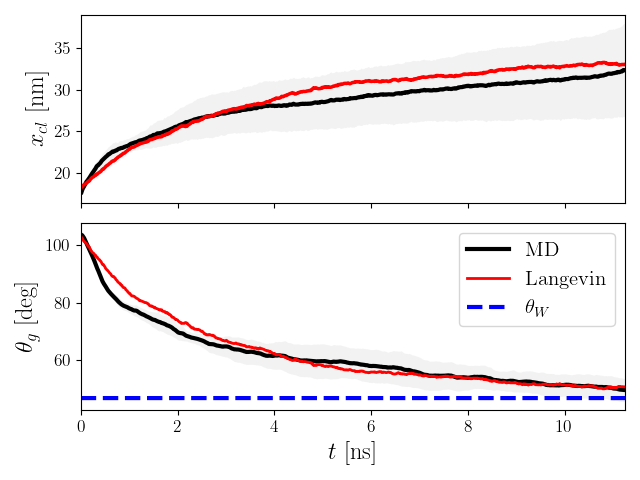

In [15]:
%matplotlib notebook

fig1, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(t_md, x_avg_md, 'k-', linewidth=3.0)
ax1.fill_between(t_md,x_avg_md-x_std_md,x_avg_md+x_std_md,color='0.9',alpha=0.5,linewidth=0.0)

ax1.plot(RS.tau*EM.t_vec, TWOPI*EM.x_ens/RS.k, 'r-', linewidth=2.5)
# ax1.fill_between(RS.tau*EM.t_vec,TWOPI*(EM.x_ens+EM.x_std)/RS.k,TWOPI*(EM.x_ens-EM.x_std)/RS.k,
#    color='r',alpha=0.5,linewidth=0.0)
ax1.set_ylabel(r'$x_{cl}$ [nm]', fontsize=AX_LABELS_FS)
ax1.set_xlim([RS.tau*EM.t_vec[0], RS.tau*EM.t_vec[-1]])
ax1.tick_params(axis='x',which='both',labelbottom=False)
ax1.tick_params(axis='y', labelsize=AX_TICKS_FS)

ax2.plot(t_md, theta_avg_md, 'k-', linewidth=3.0, label='MD')
ax2.fill_between(t_md,theta_avg_md-theta_std_md,theta_avg_md+theta_std_md,color='0.9',alpha=0.5,linewidth=0.0)

ax2.plot(RS.tau*EM.t_vec, EM.theta_g_ens, 'r-', linewidth=2.0, label='Langevin')
# ax2.fill_between(RS.tau*EM.t_vec,EM.theta_g_ens+EM.theta_std,EM.theta_g_ens-EM.theta_std,
#    color='r',alpha=0.5,linewidth=0.0)
ax2.plot(RS.tau*EM.t_vec, RS.theta_w*np.ones(EM.t_vec.shape), 'b--', linewidth=3, label=r'$\theta_W$')

ax2.set_xlabel(r'$t$ [ns]', fontsize=AX_LABELS_FS)
ax2.set_ylabel(r'$\theta_g$ [deg]', fontsize=AX_LABELS_FS)
ax2.set_xlim([RS.tau*EM.t_vec[0], RS.tau*EM.t_vec[-1]])
ax2.legend(fontsize=LEGEND_FS)
ax2.tick_params(axis='x', labelsize=AX_TICKS_FS)
ax2.tick_params(axis='y', labelsize=AX_TICKS_FS)

plt.tight_layout()
plt.savefig("/home/michele/Pictures/FiguresRoughness/CompareLangevinMD/"+'a'+a_sub_tag+'n'+n_sub_tag+".png")

In [16]:
# Old plot

"""
%matplotlib inline

fig1, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(RS.tau*EM.t_vec, TWOPI*EM.x_vec/RS.k, 'k-', linewidth=3.0)
ax1.plot(RS.tau*EM.t_vec, TWOPI*EM.x_ens/RS.k, 'r-', linewidth=2.5)
ax1.fill_between(RS.tau*EM.t_vec,TWOPI*(EM.x_ens+EM.x_std)/RS.k,TWOPI*(EM.x_ens-EM.x_std)/RS.k,
                 color='r',alpha=0.5,linewidth=0.0)
ax1.set_ylabel(r'$x_{cl}$ [nm]')#, fontsize=30.0)
ax1.set_xlim([RS.tau*EM.t_vec[0], RS.tau*EM.t_vec[-1]])
ax1.tick_params(axis='x',which='both',labelbottom=False)
ax1.tick_params(axis='y')#, labelsize=25)

ax2.plot(RS.tau*EM.t_vec, EM.theta_g_vec, 'k-', linewidth=3.0)
ax2.plot(RS.tau*EM.t_vec, EM.theta_g_ens, 'r-', linewidth=2.0, label='Langevin')
ax2.fill_between(RS.tau*EM.t_vec,EM.theta_g_ens+EM.theta_std,EM.theta_g_ens-EM.theta_std,
                 color='r',alpha=0.5,linewidth=0.0)
ax2.plot(RS.tau*EM.t_vec, RS.theta_w*np.ones(EM.t_vec.shape), 'b--', linewidth=3, label=r'$\theta_W$')
ax2.set_xlabel(r'$t$ [ns]')#, fontsize=30.0)
ax2.set_ylabel(r'$\theta_g$ [deg]')#, fontsize=30.0)
ax2.set_xlim([RS.tau*EM.t_vec[0], RS.tau*EM.t_vec[-1]])
ax2.legend()#fontsize=25)
ax2.tick_params(axis='x')#, labelsize=25)
ax2.tick_params(axis='y')#, labelsize=25)

plt.show()
"""

"\n%matplotlib inline\n\nfig1, (ax1, ax2) = plt.subplots(2, 1)\n\nax1.plot(RS.tau*EM.t_vec, TWOPI*EM.x_vec/RS.k, 'k-', linewidth=3.0)\nax1.plot(RS.tau*EM.t_vec, TWOPI*EM.x_ens/RS.k, 'r-', linewidth=2.5)\nax1.fill_between(RS.tau*EM.t_vec,TWOPI*(EM.x_ens+EM.x_std)/RS.k,TWOPI*(EM.x_ens-EM.x_std)/RS.k,\n                 color='r',alpha=0.5,linewidth=0.0)\nax1.set_ylabel(r'$x_{cl}$ [nm]')#, fontsize=30.0)\nax1.set_xlim([RS.tau*EM.t_vec[0], RS.tau*EM.t_vec[-1]])\nax1.tick_params(axis='x',which='both',labelbottom=False)\nax1.tick_params(axis='y')#, labelsize=25)\n\nax2.plot(RS.tau*EM.t_vec, EM.theta_g_vec, 'k-', linewidth=3.0)\nax2.plot(RS.tau*EM.t_vec, EM.theta_g_ens, 'r-', linewidth=2.0, label='Langevin')\nax2.fill_between(RS.tau*EM.t_vec,EM.theta_g_ens+EM.theta_std,EM.theta_g_ens-EM.theta_std,\n                 color='r',alpha=0.5,linewidth=0.0)\nax2.plot(RS.tau*EM.t_vec, RS.theta_w*np.ones(EM.t_vec.shape), 'b--', linewidth=3, label=r'$\theta_W$')\nax2.set_xlabel(r'$t$ [ns]')#, fontsize=30

### Analysing results of 'calibrate_noise.py'

In [17]:
!ls *.npy

diff_ode.npy  mu_f_ratio.npy	       opt_noise_xcl_vec.npy
diff_sde.npy  opt_noise_theta_vec.npy


In [18]:
opt_noise_xcl_vec = np.load('opt_noise_xcl_vec.npy')
opt_noise_theta_vec = np.load('opt_noise_theta_vec.npy')

n_range = [6,8,10,12,14,16]
a_range = [0.2,0.4,0.6,0.8,1.0]

# For plotting purposes
a_colors = ['g','r','b','c','m']
a_style = ['x','+','d','h','s']

# Check
assert len(opt_noise_xcl_vec) == len(n_range)*len(a_range), "Incorrect input length!"
assert len(opt_noise_theta_vec) == len(n_range)*len(a_range), "Incorrect input length!"

<IPython.core.display.Javascript object>


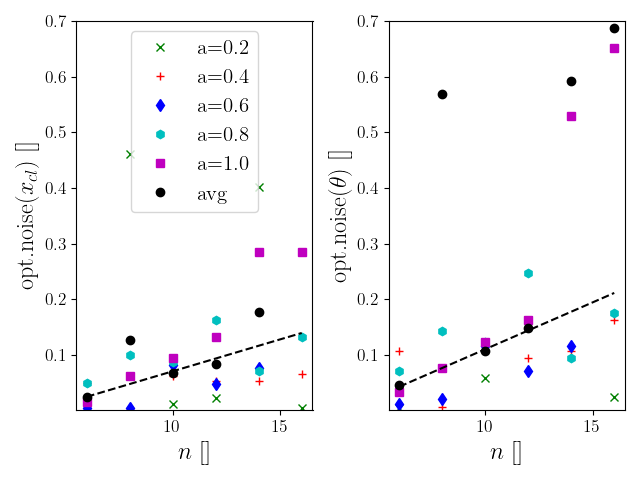

In [19]:
%matplotlib notebook
fig1, (ax1, ax2) = plt.subplots(1, 2)

k = 0
i = 0
NOISE_MAX_PLOT=0.7
NOISE_MIN_PLOT=0.001

noise_xcl_a = [[] for i in range(len(a_range))]
noise_theta_a = [[] for i in range(len(a_range))]
noise_xcl_mean = np.zeros(len(n_range))
noise_theta_mean = np.zeros(len(n_range))
noise_xcl2_mean = np.zeros(len(n_range))
noise_theta2_mean = np.zeros(len(n_range))

for n_sub in n_range :
    
    j = 0
    n_sub_tag = str(n_sub).zfill(2)
    tmp_list = []
    
    for a_sub in a_range :
        
        a_sub_tag = str(int(10*a_sub)).zfill(2)
        
        opt_noise_xcl = opt_noise_xcl_vec[k]
        opt_noise_theta = opt_noise_theta_vec[k]
        
        noise_xcl_a[j].append(opt_noise_xcl)
        noise_theta_a[j].append(opt_noise_theta)
        
        noise_xcl_mean[i] += opt_noise_xcl
        noise_theta_mean[i] += opt_noise_theta
        
        noise_xcl2_mean[i] += opt_noise_xcl**2
        noise_theta2_mean[i] += opt_noise_theta**2
        
        if i==0 :
            lb = "a="+str(a_sub)
        else :
            lb = None
        
        ax1.plot(n_sub, opt_noise_xcl, a_colors[j]+a_style[j],label=lb)
        ax1.legend(fontsize=LEGEND_FS)
        ax2.plot(n_sub, opt_noise_theta, a_colors[j]+a_style[j])
        
        j += 1
        k += 1
        
    i += 1

# Noise averaged along values of a
noise_xcl_mean /= len(a_range)
noise_theta_mean /= len(a_range)
noise_xcl2_mean /= len(a_range)
noise_theta2_mean /= len(a_range)
noise_xcl_std = np.sqrt(noise_xcl2_mean-noise_xcl_mean*noise_xcl_mean)
noise_theta_std = np.sqrt(noise_theta2_mean-noise_theta_mean*noise_theta_mean)
noise_xcl_w = 1/noise_xcl_std
noise_xcl_w /= np.sum(noise_xcl_w)
noise_theta_w = 1/noise_theta_std
noise_theta_w /= np.sum(noise_theta_w)

# Finding a common trend
p_xcl = np.polyfit(n_range, noise_xcl_mean, deg=1, w=noise_xcl_w)
p_theta = np.polyfit(n_range, noise_theta_mean, deg=1, w=noise_theta_w)

ax1.plot(n_range, noise_xcl_mean, 'ko',label='avg')
ax1.plot(n_range, np.polyval(p_xcl,n_range), 'k--')
ax1.set_xlabel(r'$n$ []',fontsize=AX_LABELS_FS)
ax1.set_ylabel('opt.noise($x_{cl}$) []',fontsize=AX_LABELS_FS)
ax1.tick_params(axis='both',which='major',labelsize=AX_TICKS_FS)
ax1.set_ylim([NOISE_MIN_PLOT,NOISE_MAX_PLOT])

ax1.legend(fontsize=LEGEND_FS)
        
ax2.plot(n_range, noise_theta_mean, 'ko')
ax2.plot(n_range, np.polyval(p_theta,n_range), 'k--')
ax2.set_xlabel(r'$n$ []',fontsize=AX_LABELS_FS)
ax2.set_ylabel(r'opt.noise($\theta$) []',fontsize=AX_LABELS_FS)
ax2.tick_params(axis='both',which='major',labelsize=AX_TICKS_FS)
ax2.set_ylim([NOISE_MIN_PLOT,NOISE_MAX_PLOT])

plt.tight_layout()